In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import bambi as bmb

%load_ext autoreload
%autoreload 2

# Ordinal Regression

In some scenarios, the response variable is discrete, like a count, and ordered. Common examples of such data come from questionnaires where the respondent is asked to rate a product, service, or experience on a scale. This scale is often referred to as a [Likert scale](https://en.wikipedia.org/wiki/Likert_scale). For example, a five-level Likert scale could be:

- 1 = Strongly disagree
- 2 = Disagree
- 3 = Neither agree nor disagree
- 4 = Agree
- 5 = Strongly agree

The result is a set of **ordered categories** where each category has an associated numeric value (1-5). However, you can't compute a meaningful difference between the categories. Moreover, the response variable can also be a discrete count, and ordered. For example, a restaurant can be rated on a scale of 1-5 stars where 1 is the worst and 5 is the best. Yes, you can compute the difference between 1 and 2 stars, but it is often treated as ordinal in an applied setting.

Ordinal data presents three challenges when modelling:

1. Unlike a count, the differences in the values are not necessarily equidistant or meaningful. For example, computing the difference between "Strongly disagree" and "Disagree". Or, in the case of the restaurant rating, it may be much harder for a restuarant to go from 4 to 5 stars than from 2 to 3 stars. 
2. The distribution of ordinal responses may be nonnormal, particularly if very low or high values are infrequently chosen.
3. The variances of the unobserved variables that underlie the observed ordered category may differ between the category, time points, etc. 

Thus, treating ordered categories as continuous is not appropriate. To this extent, Bambi supports two classes of ordinal regression models: (1) cumulative link, and (2) sequential link. Below, it is demonstrated how to fit these two models using Bambi to overcome the challenges of ordered category response data.

## Cumulative model

A cumulative model assumes that the observed ordinal variable $Y$ originates from the "categorization" of a latent continuous variable $Z$. To model the categorization process, the model assumes that there are $K$ thresholds (cutpoints) $\tau_k$ that partition $Z$ into $K+1$ observable, ordered categories. Additionally, if we assume $Z$ to have a certain distribution (e.g., Normal) with a cumulative distribution function $F$, the probability of $Y$ being equal to category $k$ is

$$Pr(Y = k) = F(\tau_k) - F(\tau_{k-1})$$

where each $F(\tau)$ is a cumulative probability. For example, suppose we have 3 categories and we are interested in the probability of $Y=3$, and have three thresholds $\tau_0 = -1, \tau_1 = 0, \tau_2 = 1$ for three categories. Additionally, if we assume $Z$ to be normally distributed with $\sigma = 1$ then

$$Pr(Y = 3) = \Phi(\tau_2) - \Phi(\tau_1) - \Phi(\tau_0)$$

How to set the thresholds? By default, Bambi uses a Normal distribution with a grid of evenly spaced $\mu$ that depends on the number of $k$ as the prior for the thresholds. Furthermore, the model specification for ordinal regression typically transforms the cumulative probabilities using the log-cumulative-odds (logit) transformation. Therefore, the learned parameters for the thresholds $\tau$ will be logits.

Lastly, as each $F(\tau)$ implies a cumulative probability for each $k$, the largest response value always has a cumulative probability of 1. Thus, we effectively do not need a parameter for it due to the law of total probability. For example, for $K = 3$ response values, we only need $K − 1 = 2$ intercepts.

### The moral intuition dataset

To illustrate an ordinal model with a cumulative link function, we will model data from a series of experiments conducted by philsophers (this example comes from Richard McElreath's [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/)). The experiments aim to collect empirical evidence relevant to debates about moral intuition, the forms of reasoning through which people develop judgments about the moral goodness and badness of actions. 

In the dataset there are 12 columns and 9930 rows, comprising data for 331 unique individuals. The response we are interested in `response`, is an integer from 1 to 7 indicating how morally permissible the participant found the action to be taken (or not) in the story. The predictors are as follows:

- `action`: a factor with levels 0 and 1 where 1 indicates that the story contained "harm caused by action is morally worse than equivalent harm caused by omission".
- `intention`: a factor with levels 0 and 1 where 1 indicates that the story contained "harm intended as the means to a goal is morally worse than equivalent harm foreseen as the side effect of a goal".
- `contact`: a factor with levels 0 and 1 where 1 indicates that the story contained "using physical contact to cause harm to a victim is morally worse than causing equivalent harm to a victim without using physical contact".

In [26]:
trolly = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Trolley.csv", sep=";")
trolly = trolly[["response", "action", "intention", "contact"]]
trolly["action"] = pd.Categorical(trolly["action"], ordered=False)
trolly["intention"] = pd.Categorical(trolly["intention"], ordered=False)
trolly["contact"] = pd.Categorical(trolly["contact"], ordered=False)
trolly["response"] = pd.Categorical(trolly["response"], ordered=True)

In [4]:
# 7 ordered categories from 1-7
trolly.response.unique()

[4, 3, 5, 2, 1, 7, 6]
Categories (7, int64): [1 < 2 < 3 < 4 < 5 < 6 < 7]

### Intercept only model

Before we fit a model with predictors, let's attempt to recover the parameters of an ordered distribution using a model with only the thresholds to get a feel for the cumulative link function. Traditionally, in Bambi if we wanted to recover the parameters of the likelihood, we would use an intercept only model and write the formula as `response ~ 1` where `1` indicates to include the intercept. However, in the case of ordinal regression, the thresholds "take the place" of the intercept. Thus, we can write the formula as `response ~ 0` to indicate that we do not want to include an intercept. To fit a cumulative ordinal model, we pass `family="cumulative"`. To compare the thresholds only model, we compute the empirical log-cumulative-odds of the categories directly from the data below. 

In [27]:
pr_k = trolly.response.value_counts().sort_index().values / trolly.shape[0]
cum_pr_k = np.cumsum(pr_k)
logit_func = lambda x: np.log(x / (1 - x))
cum_logit = logit_func(cum_pr_k)
cum_logit

/var/folders/rl/y69t95y51g90tvd6gjzzs59h0000gn/T/ipykernel_9466/1548491577.py:3: RuntimeWarning: invalid value encountered in log
  logit_func = lambda x: np.log(x / (1 - x))


array([-1.91609116, -1.26660559, -0.718634  ,  0.24778573,  0.88986365,
        1.76938091,         nan])

In [31]:
model = bmb.Model("response ~ 0", data=trolly, family="cumulative")
idata = model.fit(random_seed=1234)

/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pymc/distributions/transforms.py:56: FutureWarning: univariate_ordered has been deprecated, use ordered instead.
  warnings.warn(f"{name} has been deprecated, use ordered instead.", FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [response_threshold]


/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in add
  self.vm()
/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in add
  self.vm()
/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in add
  self.vm()
/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/comp

In [32]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
response_threshold[0],-1.916,0.030,-1.971,-1.857,0.0,0.0,4461.0,2908.0,1.0
response_threshold[1],-1.266,0.024,-1.312,-1.222,0.0,0.0,5137.0,3794.0,1.0
response_threshold[2],-0.718,0.021,-0.755,-0.674,0.0,0.0,5348.0,3578.0,1.0
response_threshold[3],0.248,0.021,0.208,0.285,0.0,0.0,5505.0,3678.0,1.0
response_threshold[4],0.891,0.022,0.848,0.931,0.0,0.0,5037.0,3301.0,1.0
response_threshold[5],1.771,0.029,1.718,1.826,0.0,0.0,5572.0,3543.0,1.0


Viewing the summary dataframe, we see a total of six cutpoints (`response_threshold`) coefficients. Why six? Remember, we get the last parameter for free, so we only need $K-1$ cutpoints. The index (using zero based indexing) of the `response_threshold` indicates the category that the cutpoint is associated with. Comparing to the empirical log-cumulative-odds computation above, the mean of the posterior distribution for each category is close to the empirical value.

As the the log cumalative link is used, we need to apply the inverse of the logit function to transform back to cumulative probabilities. Below, we plot the cumulative probabilities for each category. 

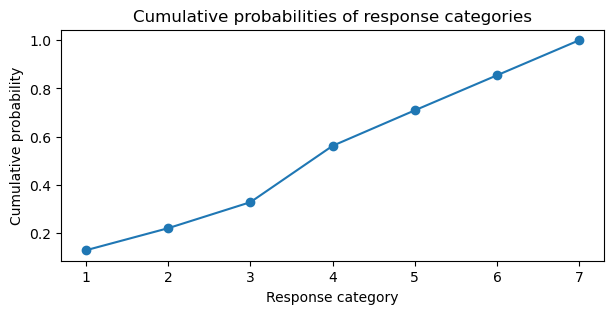

In [33]:
expit_func = lambda x: 1 / (1 + np.exp(-x))
cumprobs = expit_func(idata.posterior.response_threshold).mean(("chain", "draw"))
cumprobs = np.append(cumprobs, 1)

plt.figure(figsize=(7, 3))
plt.plot(sorted(trolly.response.unique()), cumprobs, marker='o')
plt.ylabel("Cumulative probability")
plt.xlabel("Response category")
plt.title("Cumulative probabilities of response categories");

We can take the derivative of the cumulative probabilities to get the posterior probabilities for each category.

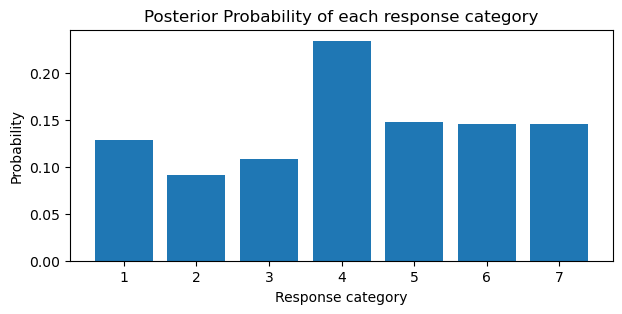

In [34]:
# derivative
ddx = np.diff(cumprobs)
probs = np.insert(ddx, 0, cumprobs[0])

plt.figure(figsize=(7, 3))
plt.bar(sorted(trolly.response.unique()), probs)
plt.ylabel("Probability")
plt.xlabel("Response category")
plt.title("Posterior Probability of each response category");

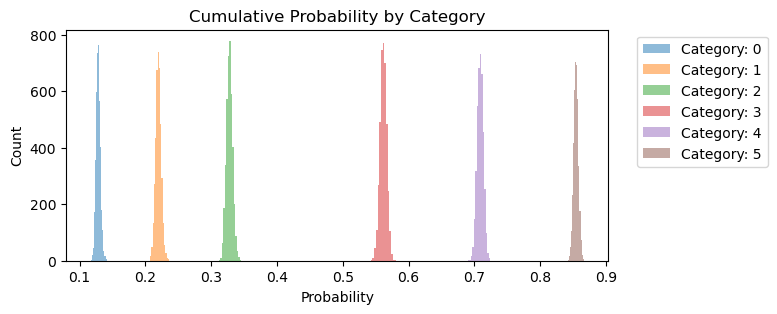

In [36]:
fig, ax = plt.subplots(figsize=(7, 3))
for i in range(6):
    outcome = expit_func(idata.posterior.response_threshold).sel(response_threshold_dim=i).to_numpy().flatten()
    ax.hist(outcome, bins=15, alpha=0.5, label=f"Category: {i}")
ax.set_xlabel("Probability")
ax.set_ylabel("Count")
ax.set_title("Cumulative Probability by Category")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left");

Notice in the plots above, the jump in probability from category 3 to 4. Additionally, the estimates of the coefficients is precise for each category. Now that we have an understanding how the cumulative link function is applied to produce ordered cumulative outcomes, we will add predictors to the model. 

### Adding predictors

In the cumulative model described above, adding predictors was explicitly left out. In this section, it is described how predictors are added to ordinal cumulative models. When adding predictor variables, what we would like is for any predictor, as it increases, predictions are moved progressively (increased) through the categories in sequence. A predictor term $\eta$ is defined as

$$\eta = \beta_1 x_1 + \beta_2 x_2 +, . . ., \beta_n x_n + \epsilon$$

Note how similar this looks to an ordinary linear model. However, there is no intercept term. This is because the intercept is replaced by the threshold $\tau$. Putting the predictor term together with the thresholds and cumulative distribution function, we obtain the probability of $Y$ being equal to a category $k$ as

$$Pr(Y = k | \eta) = F(\tau_k - \eta) - F(\tau_{k-1} - \eta)$$

The same predictor term $\eta$ is subtracted from each threshold because if we decrease the log-cumulative-odds of every outcome value $k$ below the maximum, this shifts probability mass upwards towards higher outcome values. Thus, positive $\beta$ values correspond to increasing $x$, which is associated with an increase in the mean response $Y$. The parameters to be estimated from the model are the thresholds $\tau$ and the predictor terms $\eta$ coefficients.  

To add predictors for ordinal models in Bambi, we continue to use the formula interface.

In [40]:
model = bmb.Model(
    "response ~ action + intention + contact + action:intention + contact:intention", 
    data=trolly, 
    family="cumulative"
)
idata = model.fit(random_seed=1234)

/Users/gabestechschulte/Documents/repos/bambi/bambi/formula.py:111: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")
/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pymc/distributions/transforms.py:56: FutureWarning: univariate_ordered has been deprecated, use ordered instead.
  warnings.warn(f"{name} has been deprecated, use ordered instead.", FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [response_threshold, action, intention, contact, action:intention, contact:intention]


/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.


In the summary dataframe below, we only select the predictor variables as the thresholds are not of interest at the moment.

In [12]:
az.summary(
    idata, 
    var_names=["action", "intention", "contact", 
               "action:intention", "contact:intention"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
action[1],-0.463,0.055,-0.565,-0.359,0.001,0.001,2662.0,3107.0,1.0
intention[1],-0.273,0.058,-0.375,-0.161,0.001,0.001,2326.0,2681.0,1.0
contact[1],-0.322,0.070,-0.453,-0.195,0.001,0.001,2894.0,2920.0,1.0
"action:intention[1, 1]",-0.457,0.081,-0.597,-0.302,0.002,0.001,2432.0,2892.0,1.0
"contact:intention[1, 1]",-1.284,0.100,-1.464,-1.095,0.002,0.001,2760.0,2875.0,1.0


The posterior distribution of the slopes are all negative indicating that each of these story features reduces the rating—the acceptability of the story. Below, a forest plot is used to make this insight more clear.

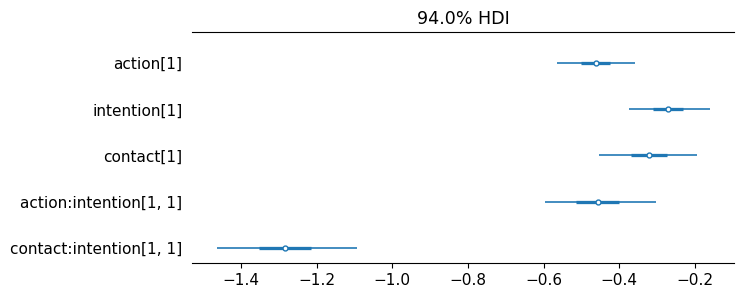

In [13]:
az.plot_forest(
    idata,
    combined=True,
    var_names=["action", "intention", "contact", 
               "action:intention", "contact:intention"],
    figsize=(7, 3),
    textsize=11
);

Again, we can plot the cumulative probability of each category. Compared to the same plot above, notice how most of the category probabilities have been shifted to the left. Additionally, there is more uncertainty for category 3, 4, and 5.

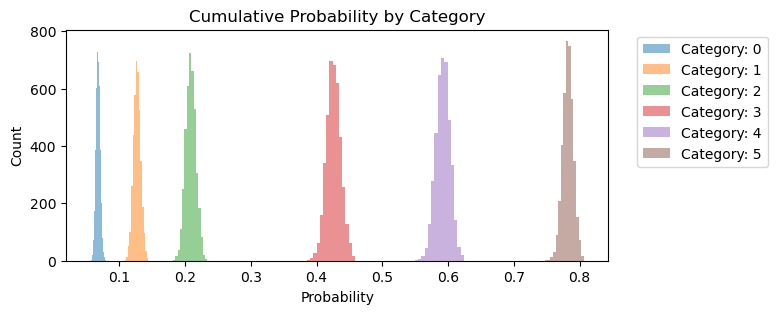

In [14]:
fig, ax = plt.subplots(figsize=(7, 3))
for i in range(6):
    outcome = expit_func(idata.posterior.response_threshold).sel(response_threshold_dim=i).to_numpy().flatten()
    ax.hist(outcome, bins=15, alpha=0.5, label=f"Category: {i}")
ax.set_xlabel("Probability")
ax.set_ylabel("Count")
ax.set_title("Cumulative Probability by Category")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left");

#### Posterior predictive distribution

To get a sense of how well the ordinal model fits the data, we can plot samples from the posterior predictive distribution. 

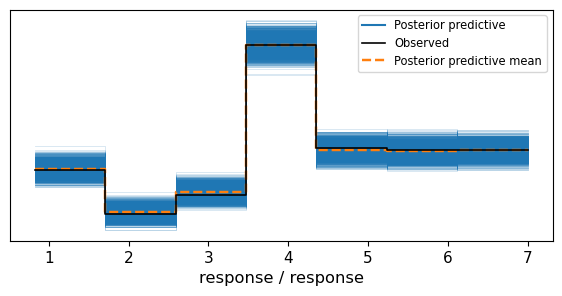

In [15]:
idata_pps = model.predict(idata=idata, kind="pps", inplace=False)

ax = az.plot_ppc(idata_pps, figsize=(7, 3), textsize=11)
ax.set_xticks(np.linspace(0.2, 7, 7))
ax.set_xticklabels(model.response_component.response_term.levels);

Looking at the observed and posterior predictive mean, the model captures the observed frequencies of the categories well. 

### Changing the default prior of cutpoints


**TO DO**

## Sequential Model

For some ordinal variables, the assumption of a **single** underlying continuous variable (as in cumulative models) may not be appropriate. If the response can be understood as being the result of a sequential process, such that a higher response category is possible only after all lower categories are achieved, then a sequential model may be more appropriate than a cumulative model.

Sequential models assume that for **every** category $k$ there is a latent continuous variable $Z$ that determines the transition between categories $k$ and $k+1$. Now, a threshold $\tau$ belongs to each latent process. If there are 3 categories, then there are 3 latent processes. If $Z_k$ is greater than the threshold $\tau_k$, the sequential process continues, otherwise it stops at category $k$. As with the cumulative model, we still assume a distribution for $Z_k$ with a cumulative distribution function $F$.

As an example, lets suppose we are interested in modeling the probability a boxer makes it to round 3. This implies that the particular boxer in question survived round 1 $Z_1 > \tau_1$ , 2 $Z_2 > \tau_2$, and 3 $Z_3 > \tau_3$. This can be written as 

$$Pr(Y = 3) = (1 - Pr(Z_1))(1 - Pr(Z_2))(1 - Pr(Z_3))$$

As in the cumulative model above, if we assume $Y$ to be normally distributed with the thresholds $\tau_0 = -1, \tau_1 = 0, \tau_2 = 1$ and cumulative distribution function $\Phi$ then

$$Pr(Y = 3) = (1 - \Phi(\tau_0))(1 - \Phi(\tau_1))(1 - \Phi(\tau_2))$$

To add predictors to this sequential model, we follow the same specification in the _Adding Predictors_ section above. Thus, the sequential model with predictor terms becomes

$$P(Y = k) = F(\tau_k - \eta) * \prod_{j=1}^{k-1}{(1 - F(\tau_j - \eta))}$$

Thus, the probability that $Y$ is equal to category $k$ is equal to the probability that it did not fall in one of the former categories $1: k-1$ multiplied by the probability that the sequential process stopped at $k$ rather than continuing past it.

### Human resources attrition dataset

To illustrate an sequential model with a stopping ratio link function, we will use data from the IBM human resources employee attrition and performance [dataset](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset). The original dataset contains 1470 rows and 35 columns. However, our goal is to model the total working years of employees using age as a predictor. This data lends itself to a sequential model as the response, total working years, is a sequential process. In order to have 10 years of working experience, it is necessarily true that the employee had 9 years of working experience. Additionally, age is choosen as a predictor as it is positively correlated with total working years.

In [41]:
attrition = pd.read_csv("data/hr_employee_attrition.tsv.txt", sep="\t")
attrition = attrition[attrition["Attrition"] == "No"]
attrition["YearsAtCompany"] = pd.Categorical(attrition["YearsAtCompany"], ordered=True)
attrition[["YearsAtCompany", "Age"]].head()

,YearsAtCompany,Age
1,10,49
3,8,33
4,2,27
5,7,32
6,1,59


Fitting a sequential model is similar to fitting a cumulative model. The only difference is that we pass `family="sratio"` to the `bambi.Model` constructor. 

In [42]:
sequence_model = bmb.Model("YearsAtCompany ~ 0 + TotalWorkingYears", data=attrition, family="sratio")
sequence_idata = sequence_model.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [YearsAtCompany_threshold, TotalWorkingYears]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 205 seconds.


In [43]:
az.summary(sequence_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
YearsAtCompany_threshold[0],-2.571,0.197,-2.930,-2.195,0.003,0.002,5509.0,2243.0,1.0
YearsAtCompany_threshold[1],-1.054,0.109,-1.248,-0.838,0.002,0.001,3092.0,2725.0,1.0
YearsAtCompany_threshold[2],-1.018,0.116,-1.252,-0.812,0.002,0.001,3545.0,2514.0,1.0
YearsAtCompany_threshold[3],-0.757,0.117,-0.970,-0.538,0.002,0.001,3458.0,2916.0,1.0
YearsAtCompany_threshold[4],-0.754,0.122,-0.969,-0.520,0.002,0.002,2900.0,2993.0,1.0
YearsAtCompany_threshold[5],0.263,0.105,0.050,0.442,0.002,0.002,2262.0,2599.0,1.0
YearsAtCompany_threshold[6],-0.501,0.143,-0.772,-0.238,0.002,0.002,3734.0,2865.0,1.0
YearsAtCompany_threshold[7],-0.079,0.140,-0.336,0.189,0.003,0.002,3139.0,2944.0,1.0
YearsAtCompany_threshold[8],0.040,0.150,-0.226,0.333,0.003,0.002,2926.0,2874.0,1.0
YearsAtCompany_threshold[9],0.401,0.150,0.132,0.692,0.003,0.002,2979.0,2550.0,1.0


**THIS IS WRONG. CUMULATIVE PROBS. CANNOT DECREASE**

The coefficients are still on the logits scale, so we need to apply the inverse of the logit function to transform back to cumulative probabilities. Below, we plot the cumulative probabilities for each category.

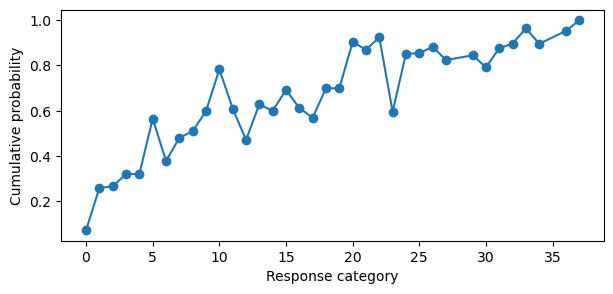

In [44]:
cumprobs = expit_func(sequence_idata.posterior.YearsAtCompany_threshold).mean(("chain", "draw"))
cumprobs = np.append(cumprobs, 1)

plt.figure(figsize=(7, 3))
plt.plot(sorted(attrition.YearsAtCompany.unique()), cumprobs, marker='o')
plt.ylabel("Cumulative probability")
plt.xlabel("Response category");

### Posterior predictive samples

Again, using the posterior predictive samples, we can visualize the model fit against the observed data. In the case of the sequential model, the model does an alright job of capturing the observed frequencies of the categories. For pedagogical purposes, this fit is sufficient.

/var/folders/rl/y69t95y51g90tvd6gjzzs59h0000gn/T/ipykernel_9466/1303656969.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sequence_model.response_component.response_term.levels);


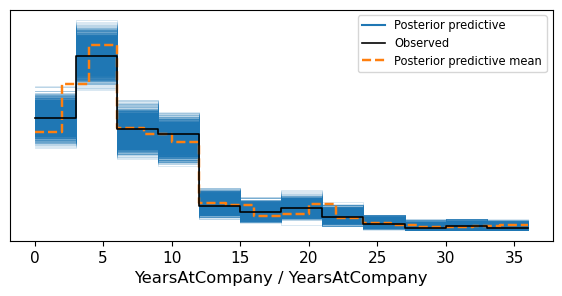

In [47]:
sequence_idata_pps = sequence_model.predict(idata=sequence_idata, kind="pps", inplace=False)

az.plot_ppc(sequence_idata_pps, figsize=(7, 3), textsize=11)
ax.set_xticklabels(sequence_model.response_component.response_term.levels);

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Sep 15 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.13.2

bambi     : 0.13.0.dev0
arviz     : 0.15.1
numpy     : 1.24.2
pandas    : 2.0.1
matplotlib: 3.7.1

Watermark: 2.3.1

